# IEMS 469 Reinforcement Learning - HW3

### This Jupyter notebook implements the Double Deep Q-Learning algorithm 

In [93]:
import torch
import collections
import typing
import numpy as np
from torch import nn, optim
from torch.nn import functional as F
import gym
import time
from itertools import count

## Experience Replay

In [128]:
_field_names = [
    "state",
    "action",
    "reward",
    "next_state",
    "done"
]
Experience = collections.namedtuple("Experience", field_names=_field_names)


class ExperienceReplayBuffer:

    def __init__(self,
                 batch_size,
                 buffer_size= None,
                 random_state= None):

        self._batch_size = batch_size
        self._buffer_size = buffer_size
        self._buffer = collections.deque(maxlen=buffer_size)
        self._random_state = np.random.RandomState() if random_state is None else random_state
        
    def __len__(self):
        return len(self._buffer)
    
    @property
    def batch_size(self):
        return self._batch_size
    
    @property
    def buffer_size(self):
        return self._buffer_size
    
    def append(self, experience: Experience):
        self._buffer.append(experience)
    
    def sample(self):
        idxs = self._random_state.randint(len(self._buffer), size=self._batch_size)
        experiences = [self._buffer[idx] for idx in idxs]
        return experiences

## Deep Q-Learning Agent

In [129]:
class Agent:
    
    def choose_action(self, state: np.array):
        raise NotImplementedError
        
    def learn(self, experiences):
        raise NotImplementedError

    def save(self, filepath) :
        raise NotImplementedError
        
    def step(self,
             state,
             action,
             reward,
             next_state,
             done):
        raise NotImplementedError


class DeepQAgent(Agent):

    def __init__(self,
                 action_size,
                 q_network_1,
                 q_network_2,
                 optimizer_fn,
                 batch_size,
                 buffer_size,
                 epsilon_decay_schedule,
                 alpha,
                 gamma,
                 update_frequency,
                 double_dqn= True,
                 seed= None):

        self._action_size = action_size
        self._device = torch.device('cuda:0')
        
        # set seeds for reproducibility
        self._random_state = np.random.RandomState() if seed is None else np.random.RandomState(seed)
        if seed is not None:
            torch.manual_seed(seed)
        
        # initialize agent hyperparameters
        _replay_buffer_kwargs = {
            "batch_size": batch_size,
            "buffer_size": buffer_size,
            "random_state": self._random_state
        }
        self._memory = ExperienceReplayBuffer(**_replay_buffer_kwargs)
        self._epsilon_decay_schedule = epsilon_decay_schedule
        self._alpha = alpha
        self._gamma = gamma
        self._double_dqn = double_dqn
        
        # initialize Q-Networks
        self._update_frequency = update_frequency
        self._online_q_network = q_network_1
        self._target_q_network = q_network_2
        self._synchronize_q_networks(self._target_q_network, self._online_q_network)        
        self._online_q_network.cuda()
        self._target_q_network.cuda()
        
        # initialize the optimizer
        self._optimizer = optimizer_fn(self._online_q_network.parameters())

        # initialize some counters
        self._number_episodes = 0
        self._number_timesteps = 0
        
    
                 
    @staticmethod
    def _soft_update_q_network_parameters(q_network_1,
                                          q_network_2,
                                          alpha):

        for p1, p2 in zip(q_network_1.parameters(), q_network_2.parameters()):
            p1.data.copy_(alpha * p2.data + (1 - alpha) * p1.data)
    

    @staticmethod
    def _synchronize_q_networks(q_network_1, q_network_2):

        _ = q_network_1.load_state_dict(q_network_2.state_dict())           
    def _uniform_random_policy(self, state: torch.Tensor) -> int:
        """Choose an action uniformly at random."""
        return self._random_state.randint(self._action_size)
        
    def _greedy_policy(self, state):

        action = (self._online_q_network(state)
                      .argmax().item())
        return action
    
    def _epsilon_greedy_policy(self, state, epsilon):

        if self._random_state.random() < epsilon:
            action = self._uniform_random_policy(state)
        else:
            action = self._greedy_policy(state)
        return action

    def choose_action(self, state):


        state_tensor = (torch.FloatTensor(state).cuda())        
            
  
        if not self.has_sufficient_experience():
            action = self._uniform_random_policy(state_tensor)
        else:
            epsilon = self._epsilon_decay_schedule(self._number_episodes)
            action = self._epsilon_greedy_policy(state_tensor, epsilon)
        return action
    
    def learn(self, experiences):


            
        states, actions, rewards, next_states, dones = (np.array(vs) for vs in zip(*experiences))
        states = torch.FloatTensor(states).cuda()
        actions = torch.FloatTensor(actions).cuda()
        rewards = torch.FloatTensor(rewards).cuda()
        next_states = torch.FloatTensor(next_states).cuda()
        dones = torch.FloatTensor(dones).cuda()
        # need to add second dimension to some tensors
        actions = (actions.long()
                          .unsqueeze(dim=1))
        rewards = rewards.unsqueeze(dim=1)
        dones = dones.unsqueeze(dim=1)
        

        target_q_values = double_q_learning_update(next_states,
                                                       rewards,
                                                       dones,
                                                       self._gamma,
                                                       self._online_q_network,
                                                       self._target_q_network)


        online_q_values = (self._online_q_network(states)
                               .gather(dim=1, index=actions))
        
 
        loss = F.huber_loss(online_q_values, target_q_values)
        
        # updates the parameters of the online network
        self._optimizer.zero_grad()
        loss.backward()
        self._optimizer.step()
        
        self._soft_update_q_network_parameters(self._target_q_network,
                                               self._online_q_network,
                                               self._alpha)
    
    def has_sufficient_experience(self):
        return len(self._memory) >= self._memory.batch_size
    
    def save(self, filepath):

        checkpoint = {
            "q-network-state": self._online_q_network.state_dict(),
            "optimizer-state": self._optimizer.state_dict(),

        }
        torch.save(checkpoint, filepath)
        
    def step(self,
             state,
             action,
             reward,
             next_state,
             done):

        experience = Experience(state, action, reward, next_state, done)
        self._memory.append(experience)
            
        if done:
            self._number_episodes += 1
        else:
            self._number_timesteps += 1
            
            # every so often the agent should learn from experiences
            if self._number_timesteps % self._update_frequency == 0 and self.has_sufficient_experience():
                experiences = self._memory.sample()
                self.learn(experiences)


## Q-Learning update for the double deep Q-learning algorithm

### Separate action selection from action evaluation

In [123]:
def select_greedy_actions(states, q_network):
    _, actions = q_network(states).max(dim=1, keepdim=True)
    return actions


def evaluate_selected_actions(states,
                              actions,
                              rewards,
                              dones,
                              gamma,
                              q_network):
    next_q_values = q_network(states).gather(dim=1, index=actions)        
    q_values = rewards + (gamma * next_q_values * (1 - dones))
    return q_values


def double_q_learning_update(states,
                             rewards,
                             dones,
                             gamma,
                             q_network_1,
                             q_network_2):
    actions = select_greedy_actions(states, q_network_1)
    q_values = evaluate_selected_actions(states, actions, rewards, dones, gamma, q_network_2)
    return q_values

# MsPacman-v0

In [36]:
env = gym.make('MsPacman-v0')

action_size = env.action_space.n
mspacman_color = 210 + 164 + 74
def preprocess_observation(obs):
      img = obs[1:176:2, ::2] # crop and downsize
      img = img.sum(axis=2) # to greyscale
      img[img==mspacman_color] = 0 # Improve contrast
      img = (img // 3 - 128).astype(np.int8) # normalize from -128 to 127
      return img.flatten()
    
    
def power_decay_schedule(episode_number,
                         decay_factor,
                         minepsilon):
    return max(decay_factor**episode_number, minepsilon)

epsilon_decay_schedule_kwargs = {
    "decay_factor": 0.99,
    "minimum_epsilon": 1e-2,
}
epsilon_decay_schedule = lambda n: power_decay_schedule(n, **epsilon_decay_schedule_kwargs)

## Architecture for the Online and Target Q-network

In [37]:
q_network_1 = nn.Sequential(
              nn.Linear(in_features = 7040, out_features = 1024),
              nn.ReLU(),
              nn.Linear(in_features = 1024, out_features = 1024),
              nn.ReLU(),
              nn.Linear(in_features = 1024, out_features = 1024),
              nn.ReLU(),
              nn.Linear(in_features = 1024, out_features = 1024),
              nn.ReLU(),
              nn.Linear(in_features = 1024, out_features = 512),
              nn.ReLU(),
              nn.Linear(in_features = 512, out_features = 512),
              nn.ReLU(),
              nn.Linear(in_features = 512, out_features = 128),
              nn.ReLU(),
              nn.Linear(128, action_size)
              )
q_network_2 = nn.Sequential(
              nn.Linear(in_features = 7040, out_features = 1024),
              nn.ReLU(),
              nn.Linear(in_features = 1024, out_features = 1024),
              nn.ReLU(),
              nn.Linear(in_features = 1024, out_features = 1024),
              nn.ReLU(),
              nn.Linear(in_features = 1024, out_features = 1024),
              nn.ReLU(),
              nn.Linear(in_features = 1024, out_features = 512),
              nn.ReLU(),
              nn.Linear(in_features = 512, out_features = 512),
              nn.ReLU(),
              nn.Linear(in_features = 512, out_features = 128),
              nn.ReLU(),
              nn.Linear(128, action_size)
              )

# Hyperparameters

In [38]:
optimizer_kwargs = {
    "lr": 1e-4,
    "betas": (0.9, 0.999),
    "eps": 1e-08,
    "weight_decay": 0,
    "amsgrad": False,
}
optimizer_fn = lambda parameters: optim.Adam(parameters, **optimizer_kwargs)                

agent_kwargs = {
    "action_size": action_size,
    "q_network_1":q_network_1,
    "q_network_2":q_network_2,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "batch_size": 128,
    "buffer_size": 100000,
    "alpha": 1e-3,
    "gamma": 0.99,
    "update_frequency": 4,
    "double_dqn": True,  # True uses Double DQN; False uses DQN 
    "seed": None,
}

# Train the agent using the Double DQN

In [39]:
def train_until_done(agent, env):
    state = env.reset()
    state = preprocess_observation(state)
    score = 0
    Q = []
    done = False
    while not done:
        action = agent.choose_action(state)
        q = agent.online_q_network(torch.FloatTensor(state).cuda()).max().item()
        next_state, reward, done, _ = env.step(action)
        next_state = preprocess_observation(next_state)
        agent.update(state, action, reward, next_state, done)
        state = next_state
        score += reward
        Q.append(q)
    return score, np.mean(Q)


def train(agent,
          env,
          checkpoint_filepath,
          max_train_time,
          maximum_timesteps=None):
    start_time = time.time()
    scores = []
    Qs = []
    most_recent_scores = collections.deque(maxlen=100)
    for i in count():
        if maximum_timesteps is None:
            score, Q = train_until_done(agent, env)       
        scores.append(score)
        Qs.append(Q)
        most_recent_scores.append(score)
        
        average_score = sum(most_recent_scores) / len(most_recent_scores)
        if (i + 1) % 10 == 0:
            print(f"\rEpisode {i + 1}\tAverage Score: {average_score:.2f}")
        if (i + 1) % 100 == 0:
            agent.save(checkpoint_filepath)
        current_time = time.time()
        elapsed_time = current_time - start_time
        if elapsed_time >= max_train_time:
            break
    return scores, Qs

In [40]:
double_dqn_agent = DeepQAgent(**agent_kwargs)

double_dqn_scores, double_dqn_Q = train(double_dqn_agent,
                          env,
                          "double-dqn-checkpoint-mspacman.pth",
                          max_train_time = 8*60*60)

Episode 10	Average Score: 235.00
Episode 20	Average Score: 229.50
Episode 30	Average Score: 244.00
Episode 40	Average Score: 277.75
Episode 50	Average Score: 296.20
Episode 60	Average Score: 319.67
Episode 70	Average Score: 389.86
Episode 80	Average Score: 428.12
Episode 90	Average Score: 463.00
Episode 100	Average Score: 479.10
Episode 110	Average Score: 524.00
Episode 120	Average Score: 555.80
Episode 130	Average Score: 576.70
Episode 140	Average Score: 596.90
Episode 150	Average Score: 622.70
Episode 160	Average Score: 653.50
Episode 170	Average Score: 646.10
Episode 180	Average Score: 660.80
Episode 190	Average Score: 669.90
Episode 200	Average Score: 677.60
Episode 210	Average Score: 691.40
Episode 220	Average Score: 696.70
Episode 230	Average Score: 729.90
Episode 240	Average Score: 743.80
Episode 250	Average Score: 752.50
Episode 260	Average Score: 730.70
Episode 270	Average Score: 704.20
Episode 280	Average Score: 669.10
Episode 290	Average Score: 639.80
Episode 300	Average Sco

## Maximum of Q function versus episodes

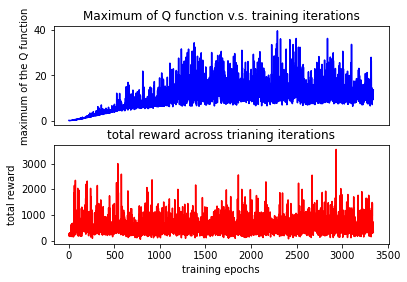

In [55]:
import matplotlib.pyplot as plt



plt.figure()
plt.subplot(211)
plt.plot(double_dqn_Q, 'b-')
plt.xticks([])
plt.ylabel('maximum of the Q function')
plt.title('Maximum of Q function v.s. training iterations')


plt.subplot(212)
plt.plot(double_dqn_scores, 'r-')
plt.xlabel('training epochs')
plt.ylabel('total reward')
plt.title('total reward across trianing iterations')
plt.show()

# CartPole-v0

In [124]:
env = gym.make('CartPole-v0')
action_size = env.action_space.n

# Architecture for the Online and Target Q-network

In [125]:
q_network_1 = nn.Sequential(
              nn.Linear(in_features = 4, out_features=512),
              nn.ReLU(),
              nn.Linear(in_features = 512, out_features = 128),
              nn.ReLU(),
              nn.Linear(in_features = 128, out_features = action_size))
q_network_2 = nn.Sequential(
              nn.Linear(in_features = 4, out_features=512),
              nn.ReLU(),
              nn.Linear(in_features = 512, out_features = 128),
              nn.ReLU(),
              nn.Linear(in_features = 128, out_features = action_size))

## Hyperparameters

In [126]:
optimizer_kwargs = {
    "lr": 1e-3,
    "betas": (0.9, 0.999),
    "eps": 1e-08,
    "weight_decay": 0,
    "amsgrad": False,
}
optimizer_fn = lambda parameters: optim.Adam(parameters, **optimizer_kwargs)                

agent_kwargs = {
    "action_size": action_size,
    "q_network_1":q_network_1,
    "q_network_2":q_network_2,
    "optimizer_fn": optimizer_fn,
    "epsilon_decay_schedule": epsilon_decay_schedule,
    "batch_size": 128,
    "buffer_size": 100000,
    "alpha": 1e-3,
    "gamma": 0.95,
    "update_frequency": 4,
    "double_dqn": True,  # True uses Double DQN; False uses DQN 
    "seed": None,
}

## Train the agent using the Double DQN 

In [127]:
def train_until_done(agent, env):
    state = env.reset()
    score = 0
    Q = []
    done = False
    while not done:
        action = agent.choose_action(state)
        q = agent._online_q_network(torch.FloatTensor(state).cuda()).max().item()
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        Q.append(q)
    return score, np.mean(Q)


def train(agen,
          env,
          checkpoint_filepath,
          max_train_time,
          maximum_timesteps=None):
    start_time = time.time()
    scores = []
    Qs = []
    most_recent_scores = collections.deque(maxlen=100)
    for i in count():
        if maximum_timesteps is None:
            score, Q = train_until_done(agent, env)       
        scores.append(score)
        Qs.append(Q)
        most_recent_scores.append(score)
        
        average_score = sum(most_recent_scores) / len(most_recent_scores)
        if (i + 1) % 100 == 0:
            print(f"\rEpisode {i + 1}\tAverage Score: {average_score:.2f}")
        current_time = time.time()
        elapsed_time = current_time - start_time
        if elapsed_time >= max_train_time:
            break
    return scores, Qs

In [67]:
double_dqn_agent = DeepQAgent(**agent_kwargs)

double_dqn_scores, double_dqn_Q = train(double_dqn_agent,
                          env,
                          "double-dqn-checkpoint-cartpole-v0.pth",
                          max_train_time = 8*60*60)

Episode 100	Average Score: 16.41
Episode 200	Average Score: 11.42
Episode 300	Average Score: 10.54
Episode 400	Average Score: 10.82
Episode 500	Average Score: 10.70
Episode 600	Average Score: 12.76
Episode 700	Average Score: 13.89
Episode 800	Average Score: 58.59
Episode 900	Average Score: 161.86
Episode 1000	Average Score: 138.36
Episode 1100	Average Score: 149.73
Episode 1200	Average Score: 162.67
Episode 1300	Average Score: 155.86
Episode 1400	Average Score: 160.81
Episode 1500	Average Score: 157.36
Episode 1600	Average Score: 154.54
Episode 1700	Average Score: 143.31
Episode 1800	Average Score: 149.44
Episode 1900	Average Score: 142.11
Episode 2000	Average Score: 142.97
Episode 2100	Average Score: 165.47
Episode 2200	Average Score: 156.60
Episode 2300	Average Score: 158.63
Episode 2400	Average Score: 165.97
Episode 2500	Average Score: 167.11
Episode 2600	Average Score: 171.44
Episode 2700	Average Score: 163.70
Episode 2800	Average Score: 162.38
Episode 2900	Average Score: 163.63
Ep

## Maximum of Q function versus episodes

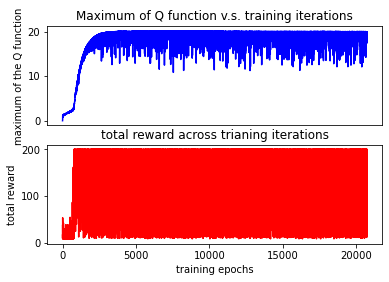

In [68]:
import matplotlib.pyplot as plt



plt.figure()
plt.subplot(211)
plt.plot(double_dqn_Q, 'b-')
plt.xticks([])
plt.ylabel('maximum of the Q function')
plt.title('Maximum of Q function v.s. training iterations')


plt.subplot(212)
plt.plot(double_dqn_scores, 'r-')
plt.xlabel('training epochs')
plt.ylabel('total reward')
plt.title('total reward across trianing iterations')
plt.show()